라이브러리

In [1]:
# imports
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy
from tensorflow.keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# 모델명(= 파일명) 설정
tank = 1
model_name = 'Test230714_tank1_nonlinear_10min'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

#시계열 10분 단위로 변경
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb.resample('10T', on='mea_dt').mean()
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.resample('10T', on='mea_dt').mean()

#null 삭제
japonica_training_sensor_val_tb.dropna(inplace=True)
japonica_validation_sensor_val_tb.dropna(inplace=True)

#인덱스 복구
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb.reset_index()
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.reset_index()

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 144이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 144].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 144].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_training_features_X = japonica_training_data[['do_mg', 'feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)

In [9]:
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6912 nVar: 2
nCar: 6912 nVar: 1
nCar: 6912 nVar: 2
nCar: 6912 nVar: 1


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [10]:
# Create model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=2))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Fit the model
history = model.fit(japonica_training_features_X_chunks, japonica_training_features_y_chunks, validation_data=(japonica_validation_features_X_chunks, japonica_validation_features_y_chunks), epochs=10000000, batch_size=100, verbose=2, callbacks=[es])
model.save(model_name+'.h5')

2023-07-14 09:23:57.987080: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 09:23:58.615587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0
/home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2023-07-14 09:23:58.984844: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10000000


2023-07-14 09:24:00.401069: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


70/70 - 2s - loss: 13.7687 - val_loss: 0.0476
Epoch 2/10000000
70/70 - 1s - loss: 0.0118 - val_loss: 0.0032
Epoch 3/10000000
70/70 - 1s - loss: 0.0029 - val_loss: 0.0027
Epoch 4/10000000
70/70 - 1s - loss: 0.0026 - val_loss: 0.0026
Epoch 5/10000000
70/70 - 1s - loss: 0.0025 - val_loss: 0.0024
Epoch 6/10000000
70/70 - 1s - loss: 0.0024 - val_loss: 0.0023
Epoch 7/10000000
70/70 - 1s - loss: 0.0023 - val_loss: 0.0022
Epoch 8/10000000
70/70 - 1s - loss: 0.0022 - val_loss: 0.0021
Epoch 9/10000000
70/70 - 1s - loss: 0.0021 - val_loss: 0.0020
Epoch 10/10000000
70/70 - 1s - loss: 0.0020 - val_loss: 0.0019
Epoch 11/10000000
70/70 - 1s - loss: 0.0019 - val_loss: 0.0018
Epoch 12/10000000
70/70 - 1s - loss: 0.0017 - val_loss: 0.0017
Epoch 13/10000000
70/70 - 1s - loss: 0.0016 - val_loss: 0.0016
Epoch 14/10000000
70/70 - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch 15/10000000
70/70 - 1s - loss: 0.0014 - val_loss: 0.0014
Epoch 16/10000000
70/70 - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 17/10000000

Epoch 119/10000000
70/70 - 0s - loss: 2.3365e-04 - val_loss: 3.2030e-04
Epoch 120/10000000
70/70 - 0s - loss: 2.0118e-04 - val_loss: 1.3782e-04
Epoch 121/10000000
70/70 - 0s - loss: 4.7307e-05 - val_loss: 5.1582e-05
Epoch 122/10000000
70/70 - 0s - loss: 3.3226e-05 - val_loss: 6.7244e-05
Epoch 123/10000000
70/70 - 0s - loss: 1.0154e-05 - val_loss: 1.0172e-06
Epoch 124/10000000
70/70 - 0s - loss: 2.9300e-06 - val_loss: 6.6606e-05
Epoch 125/10000000
70/70 - 0s - loss: 3.2703e-05 - val_loss: 6.1360e-05
Epoch 126/10000000
70/70 - 0s - loss: 1.5285e-05 - val_loss: 2.0688e-06
Epoch 127/10000000
70/70 - 0s - loss: 7.0686e-05 - val_loss: 1.2788e-05
Epoch 128/10000000
70/70 - 0s - loss: 6.8267e-05 - val_loss: 1.1881e-04
Epoch 129/10000000
70/70 - 0s - loss: 1.8522e-04 - val_loss: 0.0012
Epoch 130/10000000
70/70 - 0s - loss: 1.4146e-04 - val_loss: 9.9291e-06
Epoch 131/10000000
70/70 - 0s - loss: 1.4229e-04 - val_loss: 9.0963e-06
Epoch 132/10000000
70/70 - 0s - loss: 1.2152e-05 - val_loss: 1.9592e

Epoch 233/10000000
70/70 - 0s - loss: 2.2066e-05 - val_loss: 1.6140e-05
Epoch 234/10000000
70/70 - 0s - loss: 1.6928e-05 - val_loss: 1.2078e-06
Epoch 235/10000000
70/70 - 0s - loss: 5.7009e-06 - val_loss: 2.5823e-05
Epoch 236/10000000
70/70 - 0s - loss: 4.1999e-04 - val_loss: 2.3149e-05
Epoch 237/10000000
70/70 - 0s - loss: 9.9287e-06 - val_loss: 8.4080e-06
Epoch 238/10000000
70/70 - 0s - loss: 2.5157e-05 - val_loss: 8.4703e-06
Epoch 239/10000000
70/70 - 0s - loss: 1.6614e-05 - val_loss: 4.4092e-06
Epoch 240/10000000
70/70 - 0s - loss: 1.5902e-05 - val_loss: 1.9423e-04
Epoch 241/10000000
70/70 - 0s - loss: 6.7929e-05 - val_loss: 6.3626e-06
Epoch 242/10000000
70/70 - 0s - loss: 2.9754e-05 - val_loss: 1.1986e-04
Epoch 243/10000000
70/70 - 0s - loss: 1.5631e-04 - val_loss: 1.3918e-04
Epoch 244/10000000
70/70 - 0s - loss: 4.6979e-05 - val_loss: 9.9164e-05
Epoch 245/10000000
70/70 - 0s - loss: 2.8146e-05 - val_loss: 1.1566e-05
Epoch 246/10000000
70/70 - 0s - loss: 1.4562e-04 - val_loss: 7.9

Epoch 347/10000000
70/70 - 0s - loss: 6.3788e-07 - val_loss: 3.1856e-06
Epoch 348/10000000
70/70 - 0s - loss: 4.0432e-05 - val_loss: 2.6609e-04
Epoch 349/10000000
70/70 - 0s - loss: 1.3554e-04 - val_loss: 5.9098e-05
Epoch 350/10000000
70/70 - 0s - loss: 7.3257e-05 - val_loss: 4.6942e-06
Epoch 351/10000000
70/70 - 0s - loss: 3.6678e-05 - val_loss: 2.6016e-06
Epoch 352/10000000
70/70 - 0s - loss: 5.4039e-05 - val_loss: 9.0678e-06
Epoch 353/10000000
70/70 - 0s - loss: 4.2733e-05 - val_loss: 3.4055e-05
Epoch 354/10000000
70/70 - 0s - loss: 3.4594e-05 - val_loss: 3.6745e-05
Epoch 355/10000000
70/70 - 0s - loss: 1.7537e-04 - val_loss: 1.1547e-05
Epoch 356/10000000
70/70 - 0s - loss: 3.6214e-05 - val_loss: 3.1139e-06
Epoch 357/10000000
70/70 - 0s - loss: 3.7525e-06 - val_loss: 2.3182e-05
Epoch 358/10000000
70/70 - 0s - loss: 4.9491e-05 - val_loss: 1.6982e-04
Epoch 359/10000000
70/70 - 0s - loss: 6.0057e-05 - val_loss: 6.7337e-05
Epoch 360/10000000
70/70 - 0s - loss: 0.0029 - val_loss: 3.7106e

Epoch 461/10000000
70/70 - 0s - loss: 6.2709e-05 - val_loss: 5.2388e-05
Epoch 462/10000000
70/70 - 0s - loss: 3.6169e-05 - val_loss: 6.4901e-05
Epoch 463/10000000
70/70 - 0s - loss: 2.2456e-05 - val_loss: 2.0905e-06
Epoch 464/10000000
70/70 - 0s - loss: 8.5862e-05 - val_loss: 5.5826e-05
Epoch 465/10000000
70/70 - 1s - loss: 5.4520e-05 - val_loss: 4.2910e-05
Epoch 466/10000000
70/70 - 1s - loss: 1.7162e-05 - val_loss: 6.9230e-05
Epoch 467/10000000
70/70 - 1s - loss: 1.8819e-05 - val_loss: 3.5325e-06
Epoch 468/10000000
70/70 - 0s - loss: 8.9096e-05 - val_loss: 6.3102e-04
Epoch 469/10000000
70/70 - 1s - loss: 1.0784e-04 - val_loss: 0.0012
Epoch 470/10000000
70/70 - 1s - loss: 5.6710e-04 - val_loss: 2.2726e-05
Epoch 471/10000000
70/70 - 1s - loss: 5.4241e-06 - val_loss: 8.6181e-07
Epoch 472/10000000
70/70 - 1s - loss: 1.2903e-06 - val_loss: 1.9568e-05
Epoch 473/10000000
70/70 - 1s - loss: 3.3898e-06 - val_loss: 1.4793e-05
Epoch 474/10000000
70/70 - 1s - loss: 2.5817e-06 - val_loss: 1.0305e

Epoch 575/10000000
70/70 - 1s - loss: 2.1507e-06 - val_loss: 1.6284e-05
Epoch 576/10000000
70/70 - 0s - loss: 1.3883e-05 - val_loss: 1.9173e-06
Epoch 577/10000000
70/70 - 0s - loss: 1.5132e-05 - val_loss: 2.3342e-07
Epoch 578/10000000
70/70 - 0s - loss: 2.7779e-05 - val_loss: 3.9548e-04
Epoch 579/10000000
70/70 - 1s - loss: 1.2804e-04 - val_loss: 6.2920e-06
Epoch 580/10000000
70/70 - 1s - loss: 3.2073e-06 - val_loss: 1.0527e-05
Epoch 581/10000000
70/70 - 1s - loss: 2.0504e-05 - val_loss: 1.6401e-05
Epoch 582/10000000
70/70 - 1s - loss: 7.6125e-05 - val_loss: 1.0538e-05
Epoch 583/10000000
70/70 - 0s - loss: 1.2038e-04 - val_loss: 9.0196e-06
Epoch 584/10000000
70/70 - 0s - loss: 5.2103e-06 - val_loss: 1.8128e-05
Epoch 585/10000000
70/70 - 1s - loss: 3.1149e-05 - val_loss: 3.6496e-05
Epoch 586/10000000
70/70 - 0s - loss: 2.1094e-05 - val_loss: 5.8339e-06
Epoch 587/10000000
70/70 - 1s - loss: 2.2758e-05 - val_loss: 1.3385e-05
Epoch 588/10000000
70/70 - 1s - loss: 6.2212e-05 - val_loss: 7.4

Epoch 689/10000000
70/70 - 1s - loss: 4.5993e-05 - val_loss: 2.8923e-06
Epoch 690/10000000
70/70 - 1s - loss: 2.6353e-05 - val_loss: 1.2126e-04
Epoch 691/10000000
70/70 - 1s - loss: 6.6294e-05 - val_loss: 4.8811e-05
Epoch 692/10000000
70/70 - 1s - loss: 5.2532e-05 - val_loss: 1.1669e-06
Epoch 693/10000000
70/70 - 1s - loss: 1.7472e-06 - val_loss: 6.0397e-06
Epoch 694/10000000
70/70 - 1s - loss: 6.1663e-06 - val_loss: 1.4658e-06
Epoch 695/10000000
70/70 - 1s - loss: 1.3278e-04 - val_loss: 1.0573e-05
Epoch 696/10000000
70/70 - 1s - loss: 2.2944e-05 - val_loss: 8.6247e-06
Epoch 697/10000000
70/70 - 1s - loss: 4.0337e-06 - val_loss: 5.1274e-07
Epoch 698/10000000
70/70 - 1s - loss: 2.0644e-05 - val_loss: 1.8499e-04
Epoch 699/10000000
70/70 - 1s - loss: 4.2026e-05 - val_loss: 9.5931e-06
Epoch 700/10000000
70/70 - 1s - loss: 1.3430e-04 - val_loss: 1.5214e-05
Epoch 701/10000000
70/70 - 1s - loss: 4.2484e-06 - val_loss: 3.3461e-06
Epoch 702/10000000
70/70 - 1s - loss: 5.7043e-06 - val_loss: 1.1

모델 평가

In [11]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [12]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 1.52090448e-04  6.61822557e-02 -5.13233840e-02  1.64068490e-01
  -2.11179897e-01  1.94135219e-01 -1.99338138e-01  1.13763720e-01
  -1.35606468e-01  1.79934770e-01 -1.61894605e-01 -1.47805750e-01
  -2.18467787e-01 -1.35286897e-01  6.97311088e-02  5.99773563e-02
   1.09792724e-02  5.44677675e-02 -1.46225095e-03  2.78662853e-02
   1.34052679e-01  1.74030945e-01 -1.60415526e-02 -1.20963454e-02
  -6.13202602e-02 -1.80739880e-01  3.20767122e-03 -5.80186211e-02
  -1.83715686e-01 -1.63510069e-01 -1.29884660e-01 -2.09074929e-01
  -1.96548223e-01 -1.78032845e-01  2.58454354e-03  6.47148639e-02
  -5.71088195e-02  2.26634145e-01 -1.20920517e-01  1.82584107e-01
   9.89823118e-02 -1.90527454e-01 -2.98199207e-02 -1.06223943e-02
  -9.96404812e-02 -8.78882408e-03 -1.44134104e-01  7.13897264e-03
  -1.35930881e-01 -2.25570291e-01  3.92114408e-02 -1.61395982e-01
  -1.48274004e-01 -9.08247102e-03  2.36577213e-01 -8.66237432e-02
   2.16892026e-02  1.04745500e-01  1.56106008e-02  1.55743107e-01
  -2.71745

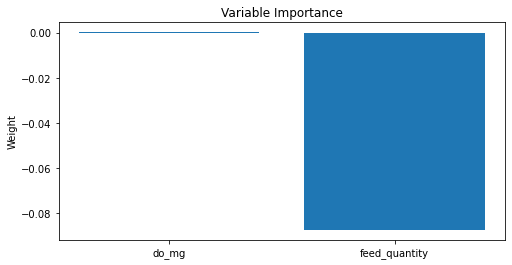

In [13]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [14]:
japonica_validation_features_X

,do_mg,feed_quantity
mea_dt,,
2021-07-21 00:00:00,7.91,0.0
2021-07-21 00:10:00,7.85,0.0
2021-07-21 00:20:00,8.00,0.0
2021-07-21 00:30:00,8.10,0.0
2021-07-21 00:40:00,8.03,0.0
...,...,...
2021-09-10 23:10:00,9.19,0.0
2021-09-10 23:20:00,9.23,0.0
2021-09-10 23:30:00,9.16,0.0


In [15]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 23:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6912 nVar: 2


In [16]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6912 nVar: 1
nCar: 6912 nVar: 1


6912


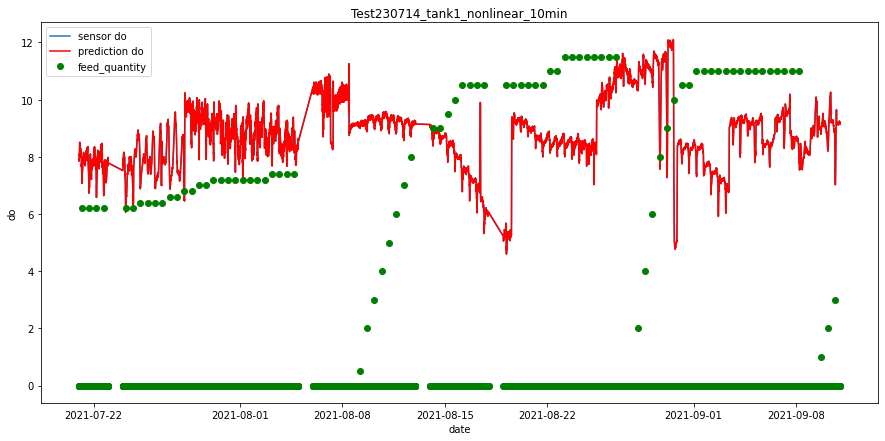

216/216 [==============================] - 1s 3ms/step - loss: 1.8654e-05
MSE // MAE // R-squared  1.8654298401088454e-05


In [17]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [18]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-31 23:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 2


In [19]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1


1440


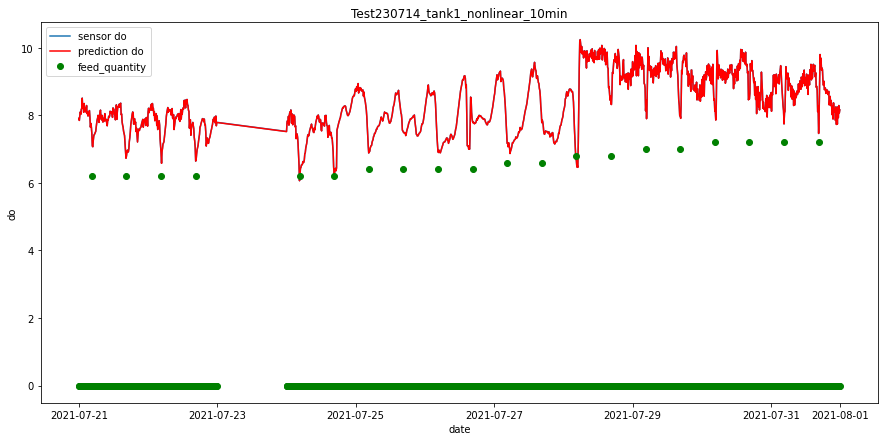

45/45 [==============================] - 0s 3ms/step - loss: 1.6451e-05
MSE // MAE // R-squared  1.6450836483272724e-05


In [20]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [21]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 23:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 144 nVar: 2


In [22]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 144 nVar: 1
nCar: 144 nVar: 1


144


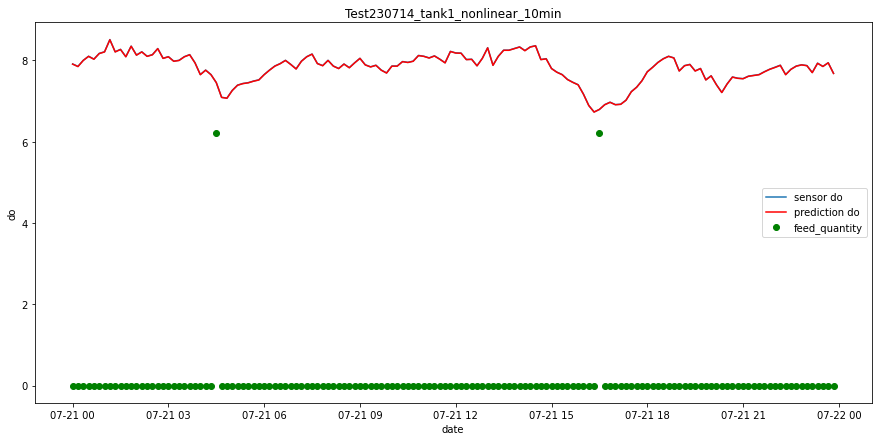

5/5 [==============================] - 0s 4ms/step - loss: 1.4700e-05
MSE // MAE // R-squared  1.4700436622661073e-05


In [23]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [24]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 2


In [25]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 1
nCar: 72 nVar: 1


72


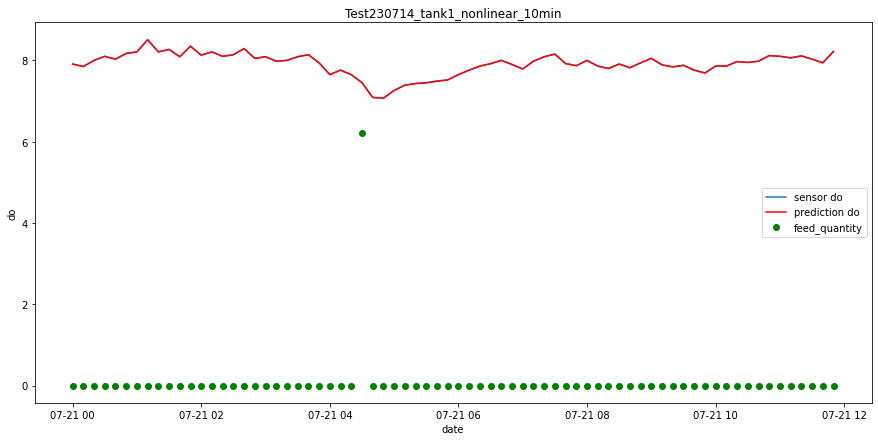

3/3 [==============================] - 0s 4ms/step - loss: 1.5091e-05
MSE // MAE // R-squared  1.5091393834154587e-05


In [26]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [27]:
japonica_validation_features_X.at['2021-07-21 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 2


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [28]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 1
nCar: 72 nVar: 1


72


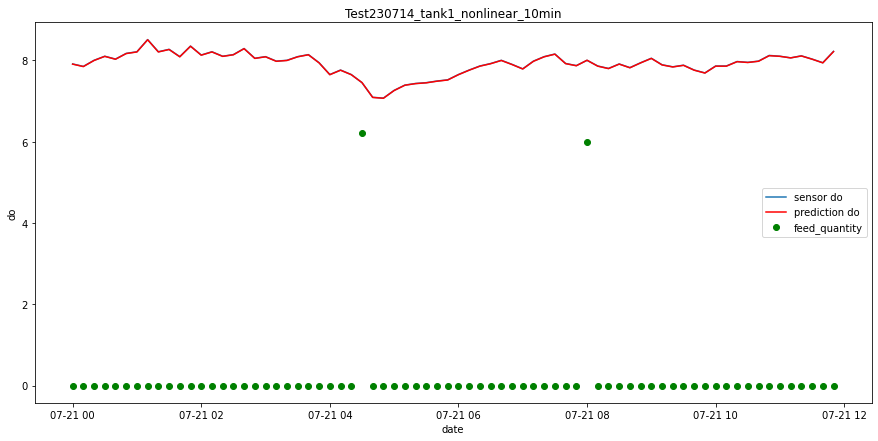

3/3 [==============================] - 0s 4ms/step - loss: 1.4888e-05
MSE // MAE // R-squared  1.4888365512888413e-05


In [29]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)